In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point
import osmnx  as ox
import networkx as nx
import matplotlib.pyplot as plt

# Ottawa Example (WIP)

In [2]:
# Algonquin
origin =  gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
origin.at[0, 'geometry'] = Point(-75.75723, 45.34900)
origin.at[0, 'name'] = 'Algonquin'

origin

,name,geometry
0,Algonquin,POINT (-75.75723 45.34900)


In [3]:
# Montfort Hospital

destination =  gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
destination.at[0, 'geometry'] = Point(-75.63844, 45.44515)
destination.at[0, 'name'] = 'Montfort'
destination

,name,geometry
0,Montfort,POINT (-75.63844 45.44515)


# London test

In [ ]:
# Wormholt Road
origin =  gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
origin.at[0, 'geometry'] = Point(-0.24081, 51.50815)
origin.at[0, 'name'] = 'Wormholt'

origin

In [ ]:
# Exhibition Road

destination =  gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
destination.at[0, 'geometry'] = Point(-0.17367, 51.49632)
destination.at[0, 'name'] = 'Museum'
destination

# Original Example

In [ ]:
# Kamppi shopping center
origin =  gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
origin.at[0, 'geometry'] = Point(24.933260, 60.169111)
origin.at[0, 'name'] = 'Kamppi'

origin

In [ ]:
# Physicum

destination =  gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
destination.at[0, 'geometry'] = Point(24.962608, 60.205301)
destination.at[0, 'name'] = 'Physicum'
destination

### 1. Function that gives back a plot with specific OSM network type

In [6]:
def osm_map(origin, destination, network = 'bike'):
    '''origin and destination <geodataframe>, network <str> drive, bike, walk
    return map including origins, destinations, and network
    '''
    
    # creating a frame for fetching OSM data
    combined = origin.append(destination)
    
    convex = combined.unary_union.convex_hull
    
    graph_extent = convex.buffer(0.02)
    
    # draw the convex hull 
    #p = gpd.GeoSeries(graph_extent)
    #p.plot()
    #plt.show()
    
    # fetching graph
    #graph = ox.graph_from_polygon(graph_extent, network_type= network)
    graph = ox.graph_from_place("Ottawa, Ontario, Canada", "bike")
        
    # Get the GeoDataFrame
    edges = ox.graph_to_gdfs(graph, nodes=False)
    
    plt.style.use('seaborn')
    
    # Plot
    ax = edges.plot(figsize=(14, 8), color='gray', linewidth=0.5, alpha=0.7)
    ax = origin.plot(ax=ax, color='red')
    ax = destination.plot(ax=ax, color='blue')
    
    plt.axis('off')
    
    
    return ax

In [ ]:
osm_map(origin, destination)
#plt.savefig('drive_network.png')

C:\Users\saif9\AppData\Local\Temp\ipykernel_39756\2594719684.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined = origin.append(destination)
C:\Users\saif9\AppData\Local\Temp\ipykernel_39756\2594719684.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<AxesSubplot: >

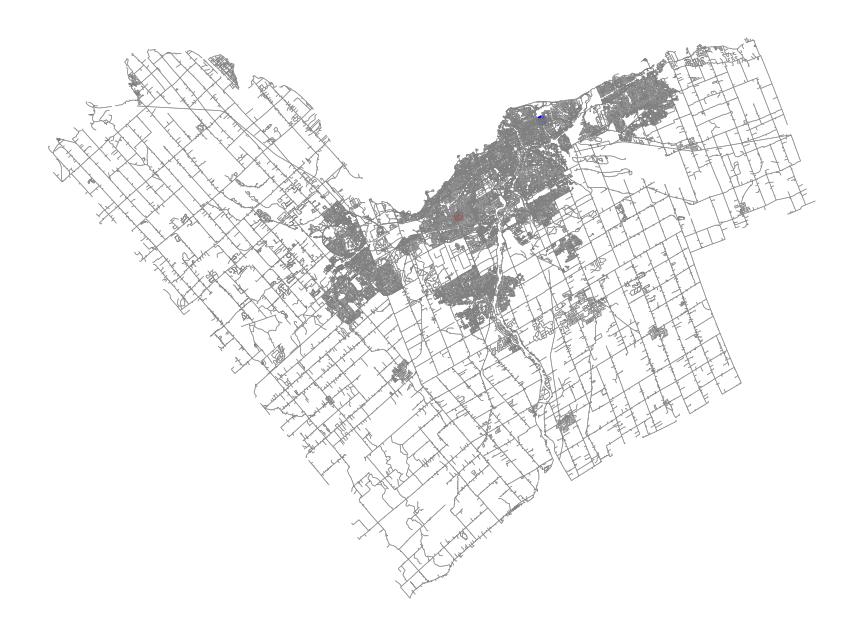

In [7]:
osm_map(origin, destination, 'bike')
#plt.savefig('bike_network.png')

In [ ]:
osm_map(origin, destination, 'walk')

### 2. Function that gives back the network as geodataframe

In [ ]:
def osm_network(origin, destination, network = 'bike'):
    '''origin and destination <geodataframe>, network <str> drive, bike, or walk
    return network <GeoDataFrame>
    '''
    
    # creating a frame for fetching OSM data
    combined = origin.append(destination)
    
    convex = combined.unary_union.convex_hull
    
    graph_extent = convex.buffer(0.02)
    
    # fetching graph
    graph = ox.graph_from_polygon(graph_extent, network_type= network)
    
    # Get the GeoDataFrame
    edges = ox.graph_to_gdfs(graph, nodes=False)
    
    return edges

In [ ]:
bike_gdf = osm_network(origin, destination)
bike_gdf.head()

In [ ]:
type(bike_gdf)

In [ ]:
# drive_g.to_file('drive.shp')

### 3. Function that gives back the shortest path. It can have many origins and destinations

In [ ]:
def shortest_path(origin, destination, network = 'bike'):
    '''origin and destination <geodataframe> crs 4326, network <str> drive, bike, walk
    return shortest path <GeoDataFrame>
    '''
    
    # creating a frame for fetching OSM data
    combined = origin.append(destination)
    
    convex = combined.unary_union.convex_hull
    
    graph_extent = convex.buffer(0.02)
    
    # fetching graph
    graph = ox.graph_from_place("Ottawa, Ontario, Canada", network_type= network)
    
    # Reproject the graph
    graph_proj = ox.project_graph(graph)
    
    # Get the GeoDataFrame
    edges = ox.graph_to_gdfs(graph_proj, nodes=False)
    
    # Get CRS info UTM
    CRS = edges.crs
    
    # Reproject all data
    origin_proj = origin.to_crs(crs=CRS)
    destination_proj = destination.to_crs(crs=CRS)
    
    # routes of shortest path
    routes = gpd.GeoDataFrame()
    
    # Get nodes from the graph
    nodes = ox.graph_to_gdfs(graph_proj, edges=False)
       
    # Find closest node from the graph --> point = (latitude, longitude)
    closest_origin_node = ox.distance.nearest_nodes(graph_proj, origin.geometry.y, origin.geometry.x)
    print(closest_origin_node)
        
    # Iterate over targets
    for tidx, target in destination_proj.iterrows():
        # Find closest node from the graph --> point = (latitude, longitude)
        closest_target_node = ox.distance.nearest_nodes(graph_proj, target.geometry.y, target.geometry.x)
        print(closest_target_node)

        # Check if origin and target nodes are the same --> if they are --> skip
        if closest_origin_node == closest_target_node:
            print("Same origin and destination node. Skipping ..")
            continue

        # Find the shortest path between the points
        route = nx.shortest_path(graph_proj, 
                                 source=closest_origin_node[0], 
                                 target=closest_target_node, weight='length')

        # Extract the nodes of the route
        route_nodes = nodes.loc[route]

        # Create a LineString out of the route
        path = LineString(list(route_nodes.geometry.values))

        # Append the result into the GeoDataFrame
        routes = routes.append([[path]], ignore_index=True)

    # Add a column name
    routes.columns = ['geometry']        

    # Set geometry
    routes = routes.set_geometry('geometry')
    
    # Set coordinate reference system
    routes.crs = nodes.crs
    
    return routes    

In [ ]:
routes = shortest_path(origin, destination, 'bike')
routes.head()

In [ ]:
routes.crs

### 4. Function that gives back a plot with the shortest path

In [30]:
def shortest_path_map(origin, destination, network = 'drive'):
    '''origin and destination <geodataframe> crs 4326, network <str> drive, bike, walk
    return map including origins, destinations, shortest path and network
    '''
    
    # creating a frame for fetching OSM data
    combined = origin.append(destination)
    
    convex = combined.unary_union.convex_hull
    
    graph_extent = convex.buffer(0.02)
    
    # fetching graph
    #graph = ox.graph_from_polygon(graph_extent, network_type= network)
    graph = ox.graph_from_place("Ottawa, Ontario, Canada", "bike")
    
    
    # Reproject the graph
    graph_proj = ox.project_graph(graph)
    
    # Get the GeoDataFrame
    edges = ox.graph_to_gdfs(graph_proj, nodes=False)
    
    # Get CRS info UTM
    CRS = edges.crs
    
    # Reproject all data
    origin_proj = origin.to_crs(crs=CRS)
    destination_proj = destination.to_crs(crs=CRS)
    
    # routes of shortest path
    routes = gpd.GeoDataFrame()
    
    # Get nodes from the graph
    nodes = ox.graph_to_gdfs(graph_proj, edges=False)
    
     # Iterate over origins and destinations
    for oidx, orig in origin_proj.iterrows():
        
        # Find closest node from the graph --> point = (latitude, longitude)
        closest_origin_node = ox.nearest_nodes(graph_proj, orig.geometry.x, orig.geometry.y)
        
        # Iterate over targets
        for tidx, target in destination_proj.iterrows():
            # Find closest node from the graph --> point = (latitude, longitude)
            closest_target_node = ox.nearest_nodes(graph_proj, target.geometry.x, target.geometry.y)
            
            # Check if origin and target nodes are the same --> if they are --> skip
            if closest_origin_node == closest_target_node:
                print("Same origin and destination node. Skipping ..")
                continue
            
            # Find the shortest path between the points
            route = nx.shortest_path(graph_proj, 
                                     source=closest_origin_node, 
                                     target=closest_target_node, weight='length')
        
            # Extract the nodes of the route
            route_nodes = nodes.loc[route]
        
            # Create a LineString out of the route
            path = LineString(list(route_nodes.geometry.values))
        
            # Append the result into the GeoDataFrame
            routes = routes.append([[path]], ignore_index=True)

    # Add a column name
    routes.columns = ['geometry']
    
    # Set geometry
    routes = routes.set_geometry('geometry')
        
    # Set coordinate reference system
    routes.crs = nodes.crs

    
    plt.style.use('seaborn')
    
    # Plot
    ax = edges.plot(figsize=(16, 10), color='gray', linewidth=0.5, alpha=0.7)
    ax = origin_proj.plot(ax=ax, color='red')
    ax = destination_proj.plot(ax=ax, color='blue')
    ax = routes.plot(ax=ax, linewidth=3, alpha = 0.8, color = 'magenta')
    
    plt.axis('off')
    
    #Storing route node coords in an array
    path_nodes = []
    for node_id in route:
        temp = graph.nodes(data=True)[node_id]
        path_nodes.append([temp['y'], temp['x']])
    print(path_nodes)
    
    
#     return ax
    return path_nodes

In [ ]:
shortest_path_map(origin, destination, 'walk')
# plt.savefig('walking_network.png')

C:\Users\saif9\AppData\Local\Temp\ipykernel_39756\1362514114.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined = origin.append(destination)
C:\Users\saif9\AppData\Local\Temp\ipykernel_39756\1362514114.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  routes = routes.append([[path]], ignore_index=True)
C:\Users\saif9\AppData\Local\Temp\ipykernel_39756\1362514114.py:90: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


[[45.3487596, -75.7566543], [45.3487403, -75.7566382], [45.3487842, -75.7563921], [45.3488317, -75.7562756], [45.3491206, -75.7558753], [45.3493027, -75.7553545], [45.3494253, -75.7550485], [45.3495187, -75.7548127], [45.3497525, -75.7542253], [45.3502183, -75.753055], [45.3503464, -75.7531485], [45.35079, -75.7519957], [45.35099, -75.7514731], [45.3511874, -75.7509592], [45.3514257, -75.7508331], [45.3514438, -75.7508436], [45.3515504, -75.7504206], [45.3516503, -75.75032], [45.3516948, -75.7496086], [45.3522338, -75.7492572], [45.3535185, -75.7464829], [45.3544599, -75.7442442], [45.3554056, -75.7420205], [45.3563448, -75.7398254], [45.3568312, -75.7386919], [45.3574183, -75.7391838], [45.3576315, -75.7386716], [45.3579249, -75.7377613], [45.3579614, -75.7376039], [45.3585738, -75.7366276], [45.3587652, -75.7365022], [45.3589001, -75.7364517], [45.35903, -75.7363426], [45.3591873, -75.7362106], [45.3595272, -75.7359252], [45.3597164, -75.7357663], [45.3597517, -75.7357367], [45.36003

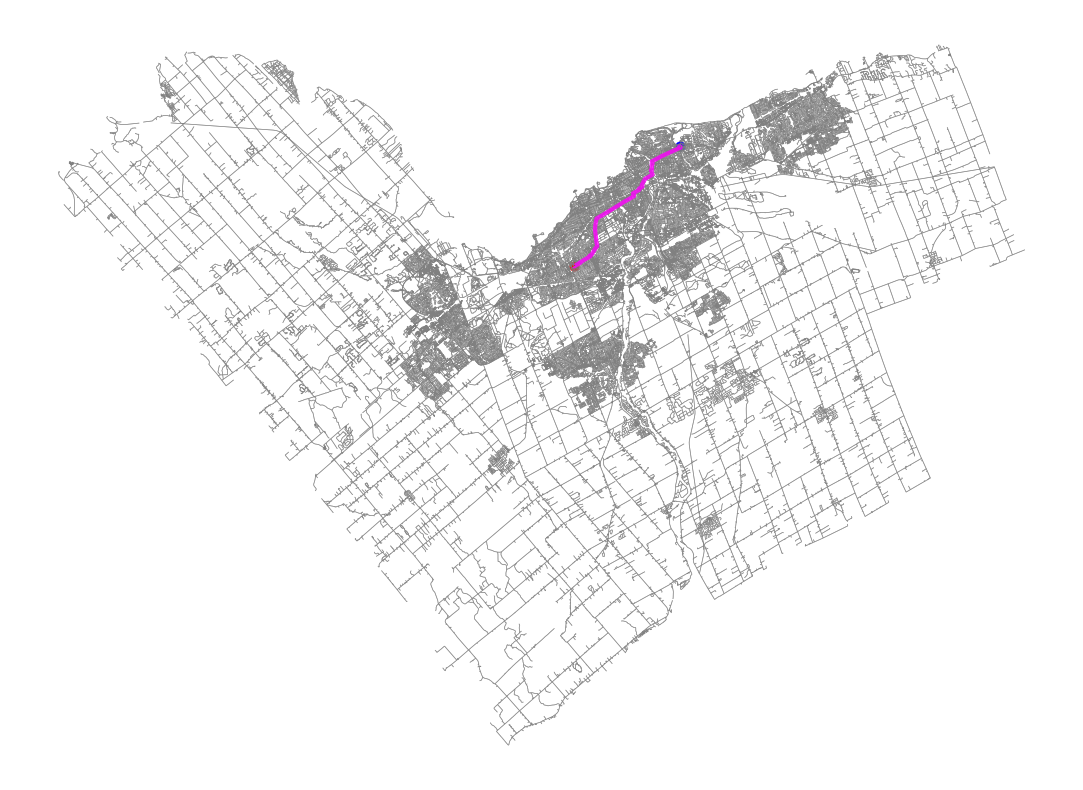

In [28]:
shortest_path_map(origin, destination, 'bike')
plt.savefig('cycling_network.png')

In [ ]:
shortest_path_map(origin, destination)
# plt.savefig('driving_network.png')

In [12]:
plt.savefig('bike_network.png')

<Figure size 800x550 with 0 Axes>